In [74]:
import tensorflow as tf
from tensorflow import keras

from keras import layers

import numpy as np
import matplotlib.pyplot as plt

In [75]:
img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [76]:
rescaling = tf.keras.Sequential([
    layers.Rescaling(1./255)
], name="DataRescalor")

In [77]:
data_augment = tf.keras.Sequential([
    layers.RandomFlip(),
    layers.RandomContrast(0.5),
    layers.RandomRotation(10),
], name="DataAugmentor")

In [78]:
def prepare(ds: tf.data.Dataset, augment=False):
    ds = ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE).shuffle(1024)
    if (augment):
        ds = ds.map(lambda x, y: (data_augment(x), y), num_parallel_calls=AUTOTUNE)
    
    ds = ds.prefetch(AUTOTUNE).cache()

    return ds

In [79]:
train_ds = prepare(tf.keras.utils.image_dataset_from_directory("data/train", image_size=img_size, batch_size=batch_size))
val_ds = prepare(tf.keras.utils.image_dataset_from_directory("data/val", image_size=img_size, batch_size=batch_size))
test_ds = prepare(tf.keras.utils.image_dataset_from_directory("data/test", image_size=img_size, batch_size=batch_size))

Found 1600 files belonging to 2 classes.
Found 414 files belonging to 2 classes.
Found 15 files belonging to 2 classes.


In [117]:
def show_batch(images, labels, pred_labels=None, num=25):
    classes = ['Cat', 'Rabbit']
    fig = plt.figure(figsize=(20, 10))
    for i in range(num):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])

        if (pred_labels is not None):
            title = f"{classes[labels[i]]} | {classes[int(np.round(pred_labels[i]))]}"
        else:
            title = classes[labels[i]]
        plt.title(title)

        plt.axis("off")

In [81]:
train_iter = train_ds.as_numpy_iterator()

In [82]:
images, labels = train_iter.next()

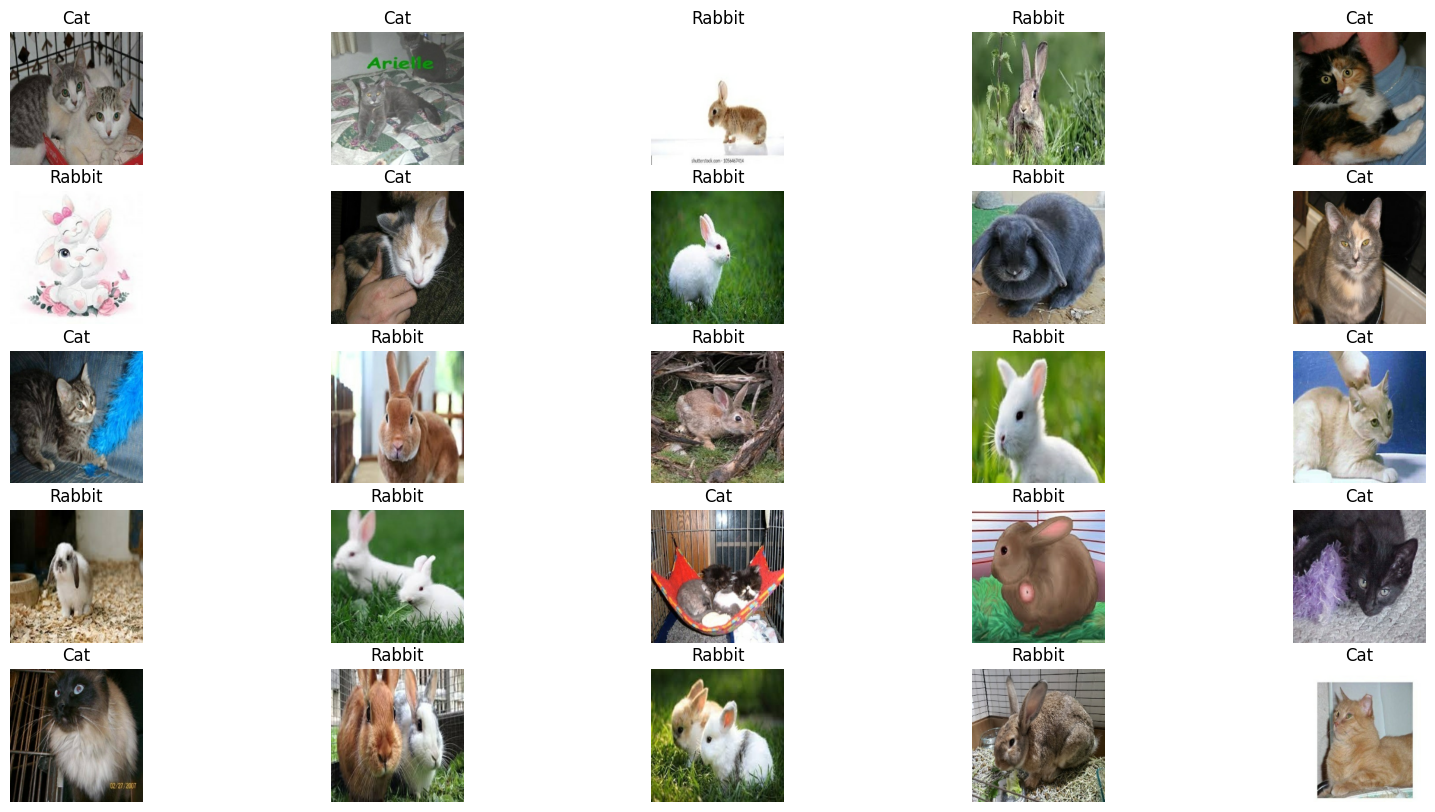

In [83]:
show_batch(images, labels)

## DL Model

In [94]:
base_model = tf.keras.applications.MobileNet(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

17225924/17225924 [==============================] - 5s 0us/step


In [95]:
model = tf.keras.Sequential([
    layers.Input((*img_size, 3)),
    data_augment,
    layers.BatchNormalization(),
    
    base_model,
    layers.BatchNormalization(),

    layers.GlobalAvgPool2D(),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid")
])

In [96]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DataAugmentor (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 batch_normalization_10 (Bat  (None, 224, 224, 3)      12        
 chNormalization)                                                
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 7, 7, 1024)       4096      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                             

In [97]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [98]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("model/cats_vs_rabbits.h5", save_best_only=True)
]

In [99]:
epochs = 100

In [100]:
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - 13s 201ms/step - loss: 0.7535 - accuracy: 0.4919 - val_loss: 0.7064 - val_accuracy: 0.5290
Epoch 2/100
50/50 [==============================] - 10s 193ms/step - loss: 0.7402 - accuracy: 0.5013 - val_loss: 0.6889 - val_accuracy: 0.5580
Epoch 3/100
50/50 [==============================] - 10s 193ms/step - loss: 0.7231 - accuracy: 0.5169 - val_loss: 0.6765 - val_accuracy: 0.5700
Epoch 4/100
50/50 [==============================] - 10s 194ms/step - loss: 0.7148 - accuracy: 0.5356 - val_loss: 0.6663 - val_accuracy: 0.5966
Epoch 5/100
50/50 [==============================] - 10s 193ms/step - loss: 0.7139 - accuracy: 0.5263 - val_loss: 0.6577 - val_accuracy: 0.6208
Epoch 6/100
50/50 [==============================] - 10s 193ms/step - loss: 0.6851 - accuracy: 0.5656 - val_loss: 0.6483 - val_accuracy: 0.6304
Epoch 7/100
50/50 [==============================] - 10s 193ms/step - loss: 0.6740 - accuracy: 0.6025 - val_loss: 0.6391 - val_accuracy:

### Increasing Learning Rate

In [103]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [104]:
hist2 = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=callbacks, initial_epoch=100)

Epoch 101/200
50/50 [==============================] - 13s 199ms/step - loss: 0.1611 - accuracy: 0.9500 - val_loss: 0.0704 - val_accuracy: 0.9855
Epoch 102/200
50/50 [==============================] - 10s 193ms/step - loss: 0.1267 - accuracy: 0.9625 - val_loss: 0.0563 - val_accuracy: 0.9879
Epoch 103/200
50/50 [==============================] - 10s 192ms/step - loss: 0.1112 - accuracy: 0.9606 - val_loss: 0.0482 - val_accuracy: 0.9879
Epoch 104/200
50/50 [==============================] - 10s 193ms/step - loss: 0.0913 - accuracy: 0.9700 - val_loss: 0.0431 - val_accuracy: 0.9879
Epoch 105/200
50/50 [==============================] - 10s 192ms/step - loss: 0.0999 - accuracy: 0.9669 - val_loss: 0.0401 - val_accuracy: 0.9903
Epoch 106/200
50/50 [==============================] - 10s 192ms/step - loss: 0.0880 - accuracy: 0.9700 - val_loss: 0.0375 - val_accuracy: 0.9903
Epoch 107/200
50/50 [==============================] - 10s 192ms/step - loss: 0.0962 - accuracy: 0.9675 - val_loss: 0.0356 -

In [106]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 214ms/step - loss: 0.0013 - accuracy: 1.0000


[0.001282849465496838, 1.0]

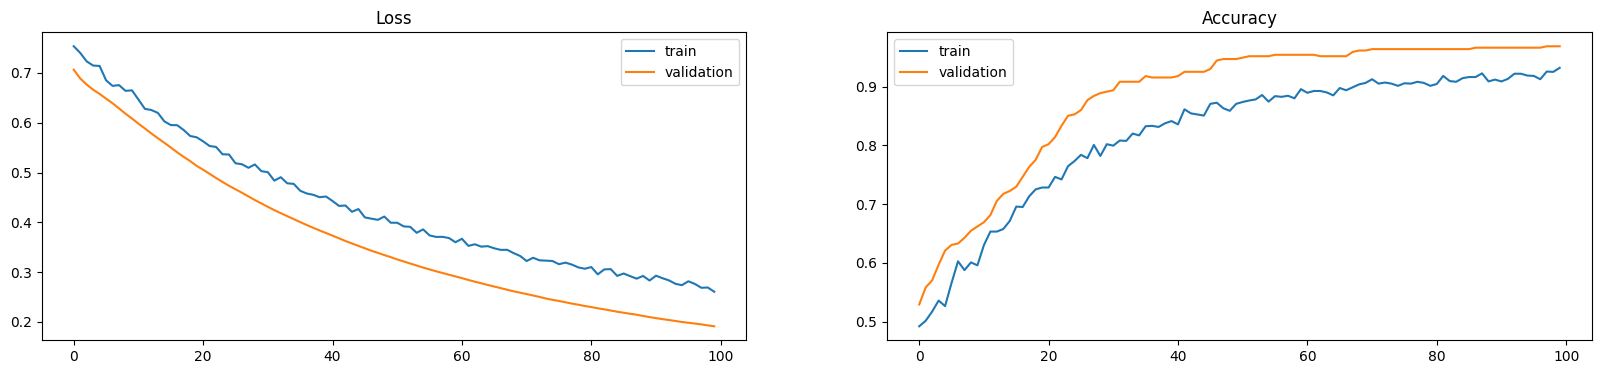

In [107]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
for i, m in enumerate(['loss', 'accuracy']):
    ax[i].plot(hist.history[m])
    ax[i].plot(hist.history["val_"+m])
    ax[i].legend(['train', 'validation'])
    ax[i].set_title(m.title())

In [108]:
test_iter = test_ds.as_numpy_iterator()

In [109]:
images, labels = test_iter.next()

In [110]:
pred_labels = model.predict(images)

1/1 [==============================] - 0s 310ms/step


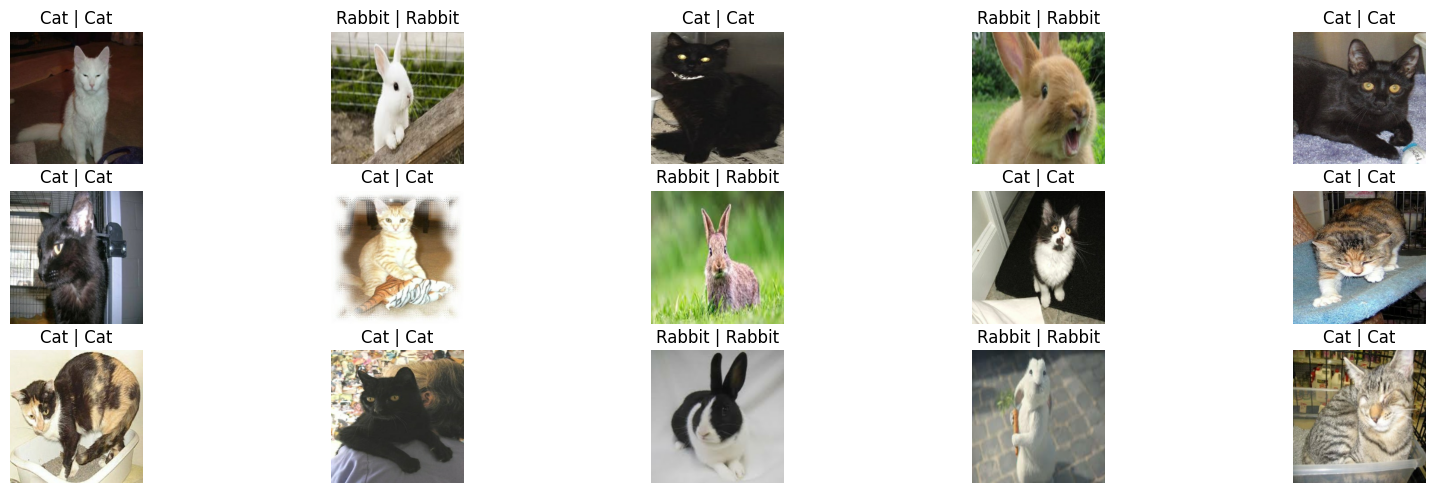

In [118]:
show_batch(images, labels, pred_labels, 15)